In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import OLSInfluence
data_path = "./data/"


1. Allen Cognitive Level (ACL) Study를 진행하는 연구자들은 ACL test 점수와 정신병리학적 수준과의 관계를 알아보기 위해 아래의 변수들을 측정하였다. 

        Response y = ACL test score
        Predictor x1 = vocabulary (Vocab) score on the Shipley Institute of Living Scale
        Predictor x2 = abstraction (Abstract) score on the Shipley Institute of Living Scale
        Predictor x3 = score on the Symbol-Digit Modalities Test (SDMT)

1-a. 23명의 환자들에 대한 데이터인 `allentestn23.txt`를 사용하여 Scatterplot matrix를 그리고 회귀모형을 적합하기에 적당한지 확인하시오. 어떤 문제가 발생할 것으로 예상되는가? 

In [2]:
test23 = pd.read_table(data_path + 'allentestn23.txt', sep="\t", index_col=0)

In [3]:
# 데이타 확인
test23.head()

,ACL,SDMT,Vocab,Abstract
Subj,,,,
6,4.5,23,24,24
8,5.9,50,18,14
10,4.8,27,14,8
15,4.5,26,15,10
17,5.9,42,30,32


In [4]:
# 기초 통계량 확인
test23.describe().T

,count,mean,std,min,25%,50%,75%,max
ACL,23.0,4.982609,0.795814,3.4,4.5,4.8,5.6,6.6
SDMT,23.0,38.739130,16.158919,2.0,26.5,42.0,50.0,63.0
Vocab,23.0,22.869565,7.213021,12.0,15.5,26.0,30.0,33.0
Abstract,23.0,22.608696,11.077164,6.0,10.0,26.0,32.0,36.0


In [5]:
test23.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 6 to 68
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ACL       23 non-null     float64
 1   SDMT      23 non-null     int64  
 2   Vocab     23 non-null     int64  
 3   Abstract  23 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 920.0 bytes


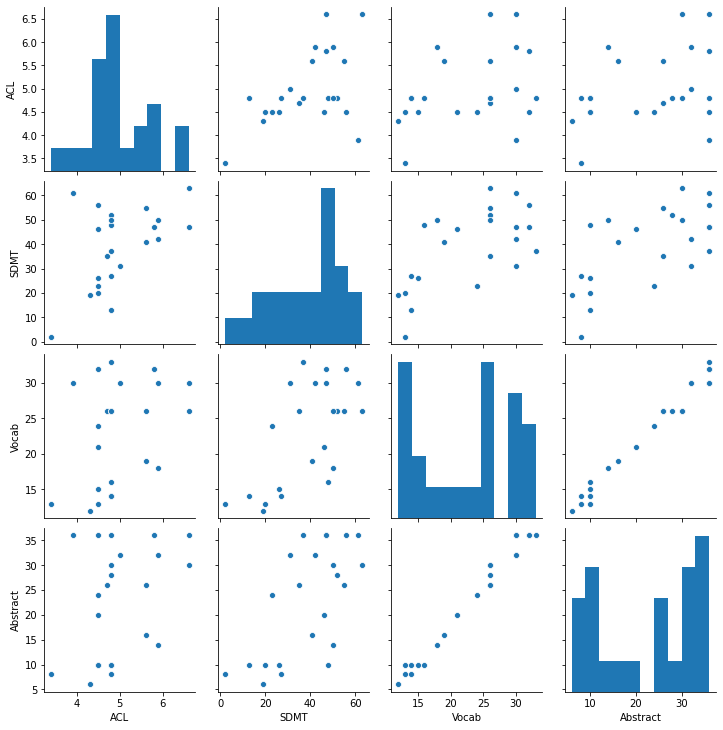

In [6]:
sns.pairplot(data=test23)
plt.show()

## 회귀모형을 적합하기에 적당하지 않은 것으로 확인됩니다.

## 그 이유는 Vocab과 Abstract 두개의 변수가 다중 공선성을 보이기 때문입니다.
## 이로 인하여 각 변수들의 개별 효과를 분리하기 어려우며, 
## 계수 추정치의 불확실성이 증가합니다.

## Scatterplot 이외 다른 방법으로 회귀진단을 해보겠습니다.

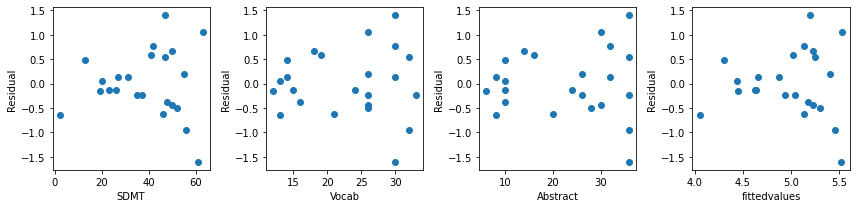

In [7]:
# 추가로 잔차 그래프 확인
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

model_test23 = smf.ols('ACL~SDMT+Vocab+Abstract', data=test23).fit()
i = 0
for col in test23.columns:
    if col == "ACL":
        continue
    axes[i].scatter(test23[col], model_test23.resid)
    axes[i].set_ylabel("Residual")
    axes[i].set_xlabel("{}".format(col))
    i += 1

axes[3].scatter(model_test23.fittedvalues, model_test23.resid)
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("fittedvalues")

fig.tight_layout()
plt.show()



## 인지할만한 패턴이 보이지 않음

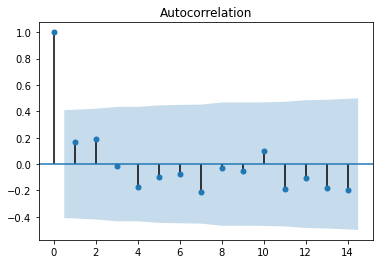

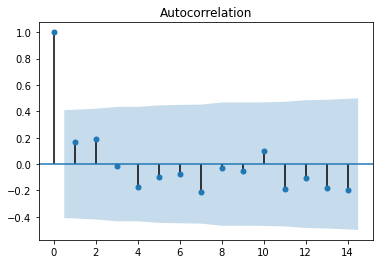

In [8]:
# 오차항의 상관성 확인
sm.graphics.tsa.plot_acf(model_test23.resid)

In [9]:
# 더빈왓슨 통계량 확인
from statsmodels.stats.stattools import durbin_watson
durbin_watson(model_test23.resid)

1.4702476245284106

## 오차항의 상관성이 보이지 않음

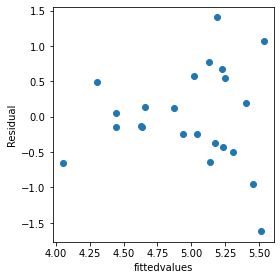

In [10]:
# 오차항의 이분산성
fig, axes = plt.subplots(1, 1, figsize=(4, 4))

model_test23 = smf.ols('ACL~SDMT+Vocab+Abstract', data=test23).fit()
axes.scatter(model_test23.fittedvalues, model_test23.resid)
axes.set_ylabel("Residual")
axes.set_xlabel("fittedvalues")

fig.tight_layout()
plt.show()


## 음..분산이 커지는 현상이 보이는 듯합니다. log와 square로 확인하겠습니다.

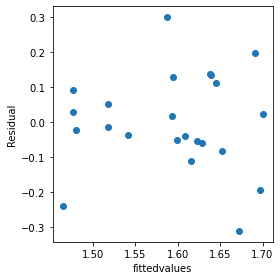

In [11]:
# 오차항의 이분산성
fig, axes = plt.subplots(1, 1, figsize=(4, 4))

model_test23 = smf.ols('np.log(ACL)~np.square(SDMT)+np.square(Vocab)+np.square(Abstract)', data=test23).fit()
axes.scatter(model_test23.fittedvalues, model_test23.resid)
axes.set_ylabel("Residual")
axes.set_xlabel("fittedvalues")

fig.tight_layout()
plt.show()

## 나아진 것인지 모르겠습니다...제가 보기엔 그거나 저거나..비슷합니다.

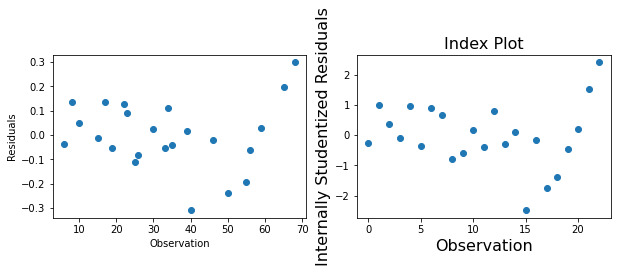

In [12]:
## 이상치 확인
mh = OLSInfluence(model_test23)
fig, ax = plt.subplots(1,2, figsize=(10, 3))
ax[0].scatter(test23.index, mh.resid)
ax[0].set_xlabel('Observation')
ax[0].set_ylabel('Residuals')
mh.plot_index('resid',threshold=3, ax = ax[1])
plt.show()

## 이상치는 없습니다.

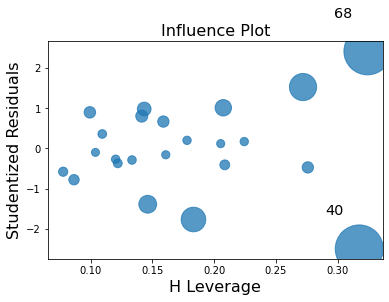

In [13]:
# 영향점 확인
mh = OLSInfluence(model_test23)
mh.plot_influence()
plt.show()

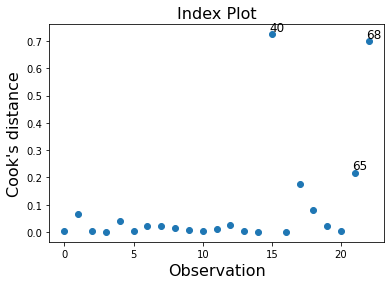

In [14]:
## 쿡 디스턴스
mh.plot_index('cook',threshold=4/(model_test23.nobs-2-1))
plt.show()

## 두가지 방법으로 영향점 확인결과 2개 또는 3개의 영향점이 관찰됩니다.
## 다만, 레버리지와 잔차가 동시에 큰 68번과 40번은 확인이 필요해 보입니다.
## 어떤 데이타인지 확인하겠습니다.

In [15]:
test23

,ACL,SDMT,Vocab,Abstract
Subj,,,,
6,4.5,23,24,24
8,5.9,50,18,14
10,4.8,27,14,8
15,4.5,26,15,10
17,5.9,42,30,32
19,4.7,35,26,26
22,5.6,41,19,16
23,4.8,13,14,10
25,4.5,46,21,20


In [16]:
# 다중공선성
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = patsy.dmatrices('ACL~SDMT+Vocab+Abstract', test23, return_type='matrix')
for i, x in enumerate(X.design_info.column_names):
    print('VIF of', x, ':', variance_inflation_factor(X, i))

VIF of Intercept : 76.84316917575055
VIF of SDMT : 1.7261852740005998
VIF of Vocab : 49.286238682129245
VIF of Abstract : 50.60308486118107


## Vocab 과 Abstract 은 다중공선성이 보입니다.

1-b. `allentestn23.txt`데이터로 회귀모형을 적합하고 다중공선성의 문제가 발생하는지 파악하시오. 어느 변수들 간의 문제가 발생하는가? 

In [17]:
# 회귀모형의 적합
model_test23 = smf.ols('ACL~SDMT+Vocab+Abstract', data=test23).fit()
model_test23.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ACL   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     2.278
Date:                Tue, 01 Dec 2020   Prob (F-statistic):              0.112
Time:                        20:44:55   Log-Likelihood:                -23.338
No. Observations:                  23   AIC:                             54.68
Df Residuals:                      19   BIC:                             59.22
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7471      1.342      2.791      0.012       0.937       6.557
SDMT           0.0233      0.013      1.827      0.083      -0.003       0.050
Vocab          0.0283      0.152      0.185      0.855      -0.291       0.347
Abstract      -0.0138      0.101     -0.137      0.892      -0.224       0.197
==============================================================================
Omnibus:                        0.553   Durbin-Watson:                   1.470
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.049
Skew:                          -0.098   Prob(JB):                        0.976
Kurtosis:                       3.111   Cond. No.                         474.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## y = 3.7471 + 0.0233 * x1 + 0.0283 * x2 - 0.0138 * x3

In [18]:
# 다중 공선성 파악
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = patsy.dmatrices('ACL~SDMT+Vocab+Abstract', test23, return_type='matrix')
for i, x in enumerate(X.design_info.column_names):
    print('VIF of', x, ':', variance_inflation_factor(X, i))

VIF of Intercept : 76.84316917575055
VIF of SDMT : 1.7261852740005998
VIF of Vocab : 49.286238682129245
VIF of Abstract : 50.60308486118107


## Vocab 과 Abstract 은 다중공선성이 보입니다.

1-3. 본 연구에서는 위에서 문제가 된 두 변수를 모형에 포함시켜야 하는 과학적 이유가 존재하여 데이터를 더 모으기로 결정하였다. `allentest.txt` 데이터를 사용하여 위의 과정을 반복하고 다중공선성 문제가 해소되었는지 확인하시오. 

In [19]:
test = pd.read_table(data_path + 'allentest.txt', sep="\t")

In [20]:
# 데이타 확인
test.head()

,Subj,ACL,Vocab,Abstract,SDMT
0,1,6.0,28,36,70
1,2,5.4,34,32,49
2,3,4.7,19,8,28
3,4,4.8,32,28,47
4,5,4.9,22,4,29


In [21]:
# 데이타 확인
test.describe()

,Subj,ACL,Vocab,Abstract,SDMT
count,69.000000,69.000000,69.000000,69.000000,69.000000
mean,35.000000,4.943478,24.101449,20.913043,42.391304
std,20.062403,0.795664,6.675559,10.599305,14.762051
min,1.000000,3.400000,10.000000,2.000000,2.000000
25%,18.000000,4.500000,19.000000,10.000000,33.000000
50%,35.000000,4.800000,26.000000,20.000000,42.000000
75%,52.000000,5.600000,30.000000,30.000000,52.000000
max,69.000000,6.600000,40.000000,40.000000,76.000000


In [22]:
# 다중 공선성 파악
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = patsy.dmatrices('ACL~SDMT+Vocab+Abstract', test, return_type='matrix')
for i, x in enumerate(X.design_info.column_names):
    print('VIF of', x, ':', variance_inflation_factor(X, i))

VIF of Intercept : 16.670443334584185
VIF of SDMT : 1.6096624348013036
VIF of Vocab : 2.0932972330713193
VIF of Abstract : 2.1674284112401403


## Vocab 과 Abstract의 다중공선성 문제가 해결되었습니다.

2\. Infection.csv는 병원에서의 감염위험에 대한 데이터이다. 아래의 변수들을 사용하여 회귀분석을 시행하고자 한다. 


    Y = InfctRsk: infection risk in hospital
    X1 = Stay: average length of patient’s stay (in days)
    X2 = Xray: a measure of frequency of giving X-rays
    X3 = Region: indication in which of 4 U.S. regions the hospital is located: north-east(1), north-central(2), south(3), west(4).


In [23]:
data = pd.read_csv(data_path + "infection.csv", index_col=0)

In [24]:
#데이타 확인
data

,Stay,Age,InfctRsk,Culture,Xray,Beds,MedSchool,Region,Census,Nurses,Facilities
ID,,,,,,,,,,,
1,7.13,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0
2,8.82,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0
3,8.34,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0
4,8.95,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0
5,11.20,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0
...,...,...,...,...,...,...,...,...,...,...,...
109,11.80,53.8,5.7,9.1,116.9,571,1,2,441,469,62.9
110,9.50,49.3,5.8,42.0,70.9,98,2,3,68,46,22.9
111,7.70,56.9,4.4,12.2,67.9,129,2,4,85,136,62.9


In [25]:
#데이타 확인
data.describe()

,Stay,Age,InfctRsk,Culture,Xray,Beds,MedSchool,Region,Census,Nurses,Facilities
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,9.648319,53.231858,4.354867,15.792920,81.628319,252.168142,1.849558,2.362832,191.371681,173.247788,43.159292
std,1.911456,4.461607,1.340908,10.234707,19.363826,192.842687,0.359097,1.009437,153.759564,139.265390,15.200861
min,6.700000,38.800000,1.300000,1.600000,39.600000,29.000000,1.000000,1.000000,20.000000,14.000000,5.700000
25%,8.340000,50.900000,3.700000,8.400000,69.500000,106.000000,2.000000,2.000000,68.000000,66.000000,31.400000
50%,9.420000,53.200000,4.400000,14.100000,82.300000,186.000000,2.000000,2.000000,143.000000,132.000000,42.900000
75%,10.470000,56.200000,5.200000,20.300000,94.100000,312.000000,2.000000,3.000000,252.000000,218.000000,54.300000
max,19.560000,65.900000,7.800000,60.500000,133.500000,835.000000,2.000000,4.000000,791.000000,656.000000,80.000000


In [26]:
#데이타 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 1 to 113
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Stay        113 non-null    float64
 1   Age         113 non-null    float64
 2   InfctRsk    113 non-null    float64
 3   Culture     113 non-null    float64
 4   Xray        113 non-null    float64
 5   Beds        113 non-null    int64  
 6   MedSchool   113 non-null    int64  
 7   Region      113 non-null    int64  
 8   Census      113 non-null    int64  
 9   Nurses      113 non-null    int64  
 10  Facilities  113 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 10.6 KB


2-a.	고려하고 있는 네 개의 변수 간의 산점도행렬을 확인하여라. 이상치가 발견되는가? Stay 변수를 기준으로 가장 큰 두 관측치를 제외하고 아래의 분석을 진행하기로 한다.

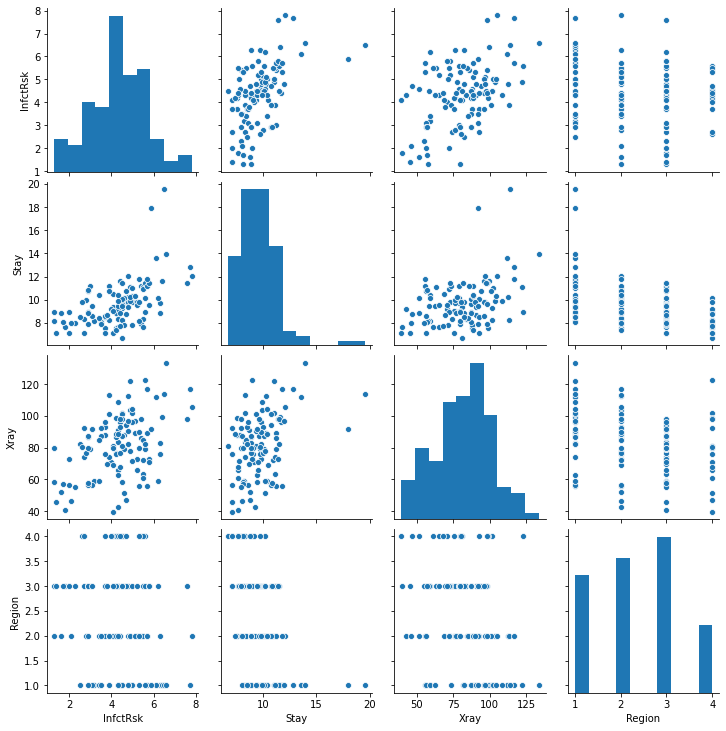

In [27]:
sns.pairplot(data=data, vars=['InfctRsk', 'Stay', 'Xray', 'Region'])
plt.show()

## Stay 에 2개의 이상치가 관측됩니다.
## Region 은 범주형으로 취급되어야 하나 수치형으로 취급됬습니다.

In [31]:
# Stay의 2개 이상한 관측치를 제거하고 분석
data2 = data[data.Stay < 15].copy()
data2

,Stay,Age,InfctRsk,Culture,Xray,Beds,MedSchool,Region,Census,Nurses,Facilities
ID,,,,,,,,,,,
1,7.13,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0
2,8.82,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0
3,8.34,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0
4,8.95,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0
5,11.20,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0
...,...,...,...,...,...,...,...,...,...,...,...
108,8.02,55.0,2.1,3.8,46.5,91,2,2,44,32,22.9
109,11.80,53.8,5.7,9.1,116.9,571,1,2,441,469,62.9
110,9.50,49.3,5.8,42.0,70.9,98,2,3,68,46,22.9


In [35]:
data2.Region = data2.Region.astype("category")

2-b.	Infection risk를 나머지 세 변수로 셜명하는 모형을 적합하여라. 각 회귀계수의 유의성을 테스트 하고 유의한 계수의 의미를 해석하시오. 

In [36]:
# Region 은 카테고리컬 변수로 변경
data2.Region.cat.categories = ['north-east', 'north-central', 'south', 'west']

# 회귀모형의 적합
model_data = smf.ols('InfctRsk~Stay+Xray+Region', data=data2).fit()
model_data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               InfctRsk   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     15.19
Date:                Tue, 01 Dec 2020   Prob (F-statistic):           3.24e-11
Time:                        20:49:56   Log-Likelihood:                -158.35
No. Observations:                 111   AIC:                             328.7
Df Residuals:                     105   BIC:                             345.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.1343      0.877     -2.433      0.017      -3.874      -0.395
Region[T.north-central]     0.1713      0.281      0.609      0.544      -0.387       0.729
Region[T.south]             0.0955      0.289      0.330      0.742      -0.477       0.668
Region[T.west]              1.0578      0.378      2.798      0.006       0.308       1.807
Stay                        0.5054      0.081      6.205      0.000       0.344       0.667
Xray                        0.0176      0.006      3.113      0.002       0.006       0.029
==============================================================================
Omnibus:                        0.341   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.843   Jarque-Bera (JB):                0.134
Skew:                          -0.078   Prob(JB):                        0.935
Kurtosis:                       3.070   Cond. No.                         800.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 유의한 계수는 p-value가 0.05보다 작은 Region[T.west], Stay, Xray 가 있습니다.
## Region[T.west]는 다른 변수가 동일 수준일 때 north-east 평균 감염수준과 비교하여 
## west가 1.0578만큼의 평균 감염위험 수준이 높다는 의미이고,
## Stay가 1증가 할 때 0.5054만큼의 감염위험 수준이 증가한다는 의미이다.
## 끝으로 XTray가 1증가 할 때 0.0176 만큼의 감염위험 수준이 있다는 의미이다.

2-c. Region이 west인 지역을 reference level로 사용하여 모형을 다시 적합하고 유의한 회귀계수의 의미를 해석하시오. B의 결과와 어떻게 다른가? 

In [37]:
# 회귀모형의 적합
model_data = smf.ols('InfctRsk~Stay+Xray+C(Region, Treatment(reference = "west"))', data=data2).fit()
model_data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               InfctRsk   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     15.19
Date:                Tue, 01 Dec 2020   Prob (F-statistic):           3.24e-11
Time:                        20:51:23   Log-Likelihood:                -158.35
No. Observations:                 111   AIC:                             328.7
Df Residuals:                     105   BIC:                             345.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -1.0764      0.721     -1.492      0.139      -2.507       0.354
C(Region, Treatment(reference="west"))[T.north-east]       -1.0578      0.378     -2.798      0.006      -1.807      -0.308
C(Region, Treatment(reference="west"))[T.north-central]    -0.8866      0.340     -2.608      0.010      -1.560      -0.213
C(Region, Treatment(reference="west"))[T.south]            -0.9624      0.323     -2.976      0.004      -1.604      -0.321
Stay                                                        0.5054      0.081      6.205      0.000       0.344       0.667
Xray                                                        0.0176      0.006      3.113      0.002       0.006       0.029
==============================================================================
Omnibus:                        0.341   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.843   Jarque-Bera (JB):                0.134
Skew:                          -0.078   Prob(JB):                        0.935
Kurtosis:                       3.070   Cond. No.                         624.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 유의한 계수는 p-value가 0.05보다 작은 Region[T.north-east], Region[T.north-central],
## Region[T.south], Stay, Xray 가 있습니다.
## Region[T.north-east]는 다른 변수가 동일 수준일 때 west 평균 감염수준과 비교하여 
## north-east가 1.0578만큼 평균 감염위험 수준이 낮다는 의미이고,
## Region[T.north-central]는 다른 변수가 동일 수준일 때 west 평균 감염수준과 비교하여 
## north-central가 0.8866만큼 평균 감염위험 수준이 낮다는 의미이고,
## Region[T.south]는 다른 변수가 동일 수준일 때 west 평균 감염수준과 비교하여 
## south가 0.9624만큼 평균 감염위험 수준이 낮다는 의미이고,
## Stay가 1증가 할 때 0.5054만큼의 감염위험 수준이 증가한다는 의미이다.
## 끝으로 XTray가 1증가 할 때 0.0176 만큼의 감염위험 수준이 있다는 의미이다.
##  
## (2-b)와 비교하여 north-east에 비해 west가 감염위험이 높다고 판단할 수 있다.